In [1]:
# Base Libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (20,7)
# plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split, 
                                    GridSearchCV, 
                                    TimeSeriesSplit, 
                                    cross_val_score
                                    )
# Classifier
from sklearn.neighbors import KNeighborsClassifier
# metrics
from sklearn.metrics import (precision_recall_curve, 
                             roc_curve, 
                             RocCurveDisplay,
                             ConfusionMatrixDisplay
                            )
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score,
                             precision_score,
                             roc_auc_score,
                             auc
                            )
from sklearn.metrics import (classification_report, 
                             confusion_matrix 
                            )
# Machine info & package version
from watermark import watermark
%load_ext watermark
%watermark -a "Fernando Bristotti" -u -d -v -m -iv                            
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


Author: Fernando Bristotti

Last updated: 2023-05-21

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

numpy     : 1.23.1
matplotlib: 3.5.2
pandas    : 1.4.4



## Load Data

In [2]:
df = pd.read_csv(r'~\src\cqf\exam3\data.csv', index_col='date', parse_dates=['date'])
df.head()

,open,high,low,close
date,,,,
2018-05-21,10.296750,10.371707,9.839116,9.882513
2018-05-22,9.807405,9.997150,9.546507,9.767875
2018-05-23,9.578131,9.676956,9.198643,9.198643
2018-05-24,7.925775,8.202485,7.767655,7.937634
2018-05-25,8.162955,8.408042,7.771608,7.826950


In [3]:
df.describe()

,open,high,low,close
count,1240.000000,1240.000000,1240.000000,1240.000000
mean,13.421986,13.636153,13.196804,13.414884
std,5.237729,5.339208,5.150517,5.252697
min,4.707236,5.179236,4.613687,4.800786
25%,9.945838,10.127989,9.820758,9.973879
50%,11.684253,11.839912,11.536278,11.706667
75%,16.924746,17.212493,16.624367,16.926054
max,28.526247,30.003359,28.440277,29.479727


In [4]:
df.isnull().sum()

open     0
high     0
low      0
close    0
dtype: int64

### Feature Specification

In [5]:
df['oc'] = df.open - df.close
df['hl'] = df.high - df.low
df['sign'] = np.log(df.close / df.close.shift(1))

In [6]:
df[['oc','hl']].values

array([[ 0.41423706,  0.5325905 ],
       [ 0.03953005,  0.45064257],
       [ 0.37948848,  0.47831361],
       ...,
       [ 0.94      ,  1.25      ],
       [-0.22      ,  0.5       ],
       [ 0.16      ,  0.54      ]])

In [7]:
df['signal'] = np.where(df.close.shift(-1) > df.close * 0.995, 1, -1)

In [8]:
df.signal.value_counts()

 1    763
-1    477
Name: signal, dtype: int64

<AxesSubplot:xlabel='date'>

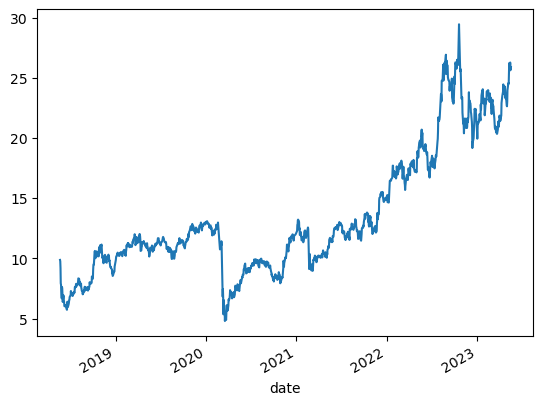

In [9]:
df.close.plot()

In [10]:
X = df[['oc','hl']].values
y = df.signal.values

### Split Data

In [11]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 992, 248


### Fit Model

In [12]:
# Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", KNeighborsClassifier())
]) 
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier())])

### Predict Model

In [13]:
# Predicting the test dataset
y_pred = model.predict(X_test)

# Predict Probabilities
y_proba = model.predict_proba(X_test)

In [14]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.7087, Test Accuracy: 0.5766


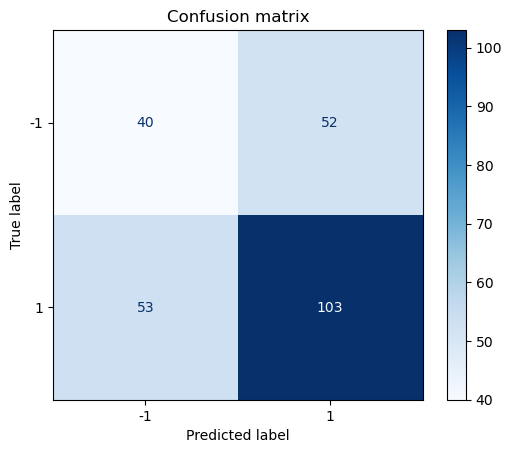

In [15]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix')
plt.show()

### Classification Report

In [16]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.43      0.43      0.43        92
           1       0.66      0.66      0.66       156

    accuracy                           0.58       248
   macro avg       0.55      0.55      0.55       248
weighted avg       0.58      0.58      0.58       248



In [17]:
model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': KNeighborsClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [18]:
# Example: First 2 split
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [19]:
# Perform Gridsearch and fit
param_grid = {"classifier__n_neighbors": np.arange(1,51,1)}

grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='roc_auc', verbose=1)

In [20]:
# Best Params & Scores
print(f"Optimal Neighbours: {grid_search.best_params_['classifier__n_neighbors']}, Best Scors: {round(grid_search.best_score_,4)}")

Optimal Neighbours: 3, Best Scors: 0.531


### Tuned Model

In [21]:
# Instantiate KNN model with search param
clf = KNeighborsClassifier(n_neighbors = grid_search.best_params_['classifier__n_neighbors'])
# Fit the model
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [22]:
# Predicting the test dataset
y_pred = clf.predict(X_test)
# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.7823 
 Test Accuracy 		: 0.5282


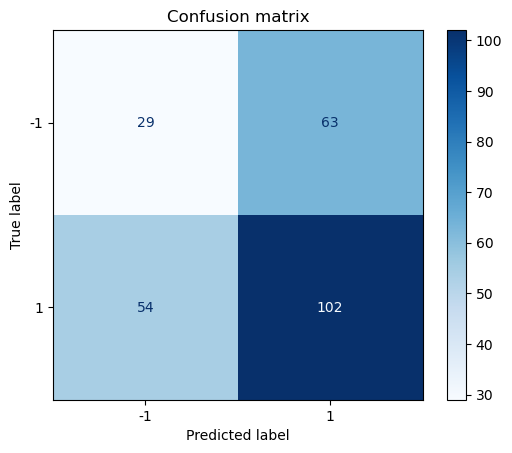

In [23]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix')
plt.show()

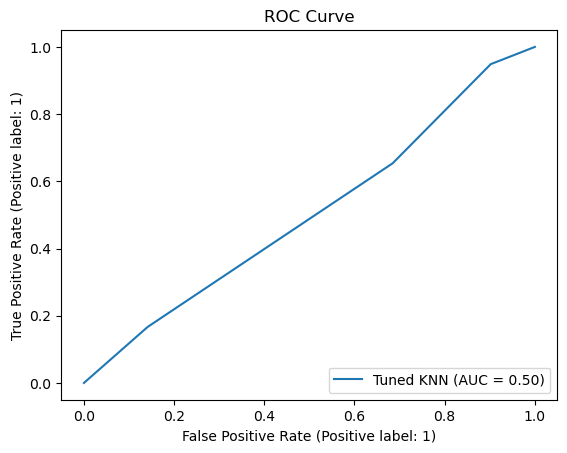

In [24]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            clf, 
            X_test, 
            y_test,
            name='Tuned KNN')
disp_roc.ax_.set_title('ROC Curve')
plt.show()

In [25]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.35      0.32      0.33        92
           1       0.62      0.65      0.64       156

    accuracy                           0.53       248
   macro avg       0.48      0.48      0.48       248
weighted avg       0.52      0.53      0.52       248



## Trading Strategy

In [32]:
# Subsume into a new dataframe
df1 = df.copy()                      # df[-len(X_test)
df1['signal'] = clf.predict(X)       # clf.predict(X_test)

In [33]:
df1.signal

date
2018-05-21    1
2018-05-22    1
2018-05-23   -1
2018-05-24   -1
2018-05-25    1
             ..
2023-05-15   -1
2023-05-16    1
2023-05-17    1
2023-05-18    1
2023-05-19    1
Name: signal, Length: 1240, dtype: int32

In [34]:
# Daily Returns
df1['returns'] = np.log(df1.close).diff().fillna(0)

# Strategy Returns
df1['strategy'] = df1.returns * df1.signal.shift(1).fillna(0)

# Localize index for pyfolio
df1.index = df1.index.tz_localize('utc')

In [35]:
# Check the output
df1.tail(10)

,open,high,low,close,oc,hl,sign,signal,returns,strategy
date,,,,,,,,,,
2023-05-08 00:00:00+00:00,24.45,24.63,24.21,24.51,-0.06,0.42,0.021027,1,0.021027,0.021027
2023-05-09 00:00:00+00:00,24.41,24.80,24.24,24.59,-0.18,0.56,0.003259,-1,0.003259,0.003259
2023-05-10 00:00:00+00:00,24.59,24.82,24.33,24.53,0.06,0.49,-0.002443,-1,-0.002443,0.002443
2023-05-11 00:00:00+00:00,24.13,25.48,23.93,25.43,-1.30,1.55,0.036033,1,0.036033,-0.036033
2023-05-12 00:00:00+00:00,25.58,26.74,25.48,26.25,-0.67,1.26,0.031736,1,0.031736,0.031736
2023-05-15 00:00:00+00:00,26.06,26.15,25.40,25.66,0.40,0.75,-0.022733,-1,-0.022733,-0.022733
2023-05-16 00:00:00+00:00,26.11,27.03,26.08,26.30,-0.19,0.95,0.024636,1,0.024636,-0.024636
2023-05-17 00:00:00+00:00,26.60,26.76,25.51,25.66,0.94,1.25,-0.024636,1,-0.024636,-0.024636
2023-05-18 00:00:00+00:00,25.59,25.85,25.35,25.81,-0.22,0.50,0.005829,1,0.005829,0.005829


### Return Analysis

In [36]:
import pyfolio as pf

Start date,2018-05-21
End date,2023-05-19
Total months,59
,Backtest
Annual return,516.569%
Cumulative returns,771179.876%
Annual volatility,48.325%
Sharpe ratio,4.03
Calmar ratio,11.10
Stability,0.97
Max drawdown,-46.522%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.52,2020-02-28,2020-03-16,2020-04-02,25
1,42.45,2022-09-22,2023-05-17,NaT,NaN
2,18.64,2018-05-25,2018-06-01,2018-06-18,17
3,16.74,2022-05-23,2022-07-27,2022-08-18,64
4,9.06,2021-02-24,2021-02-26,2021-03-05,8


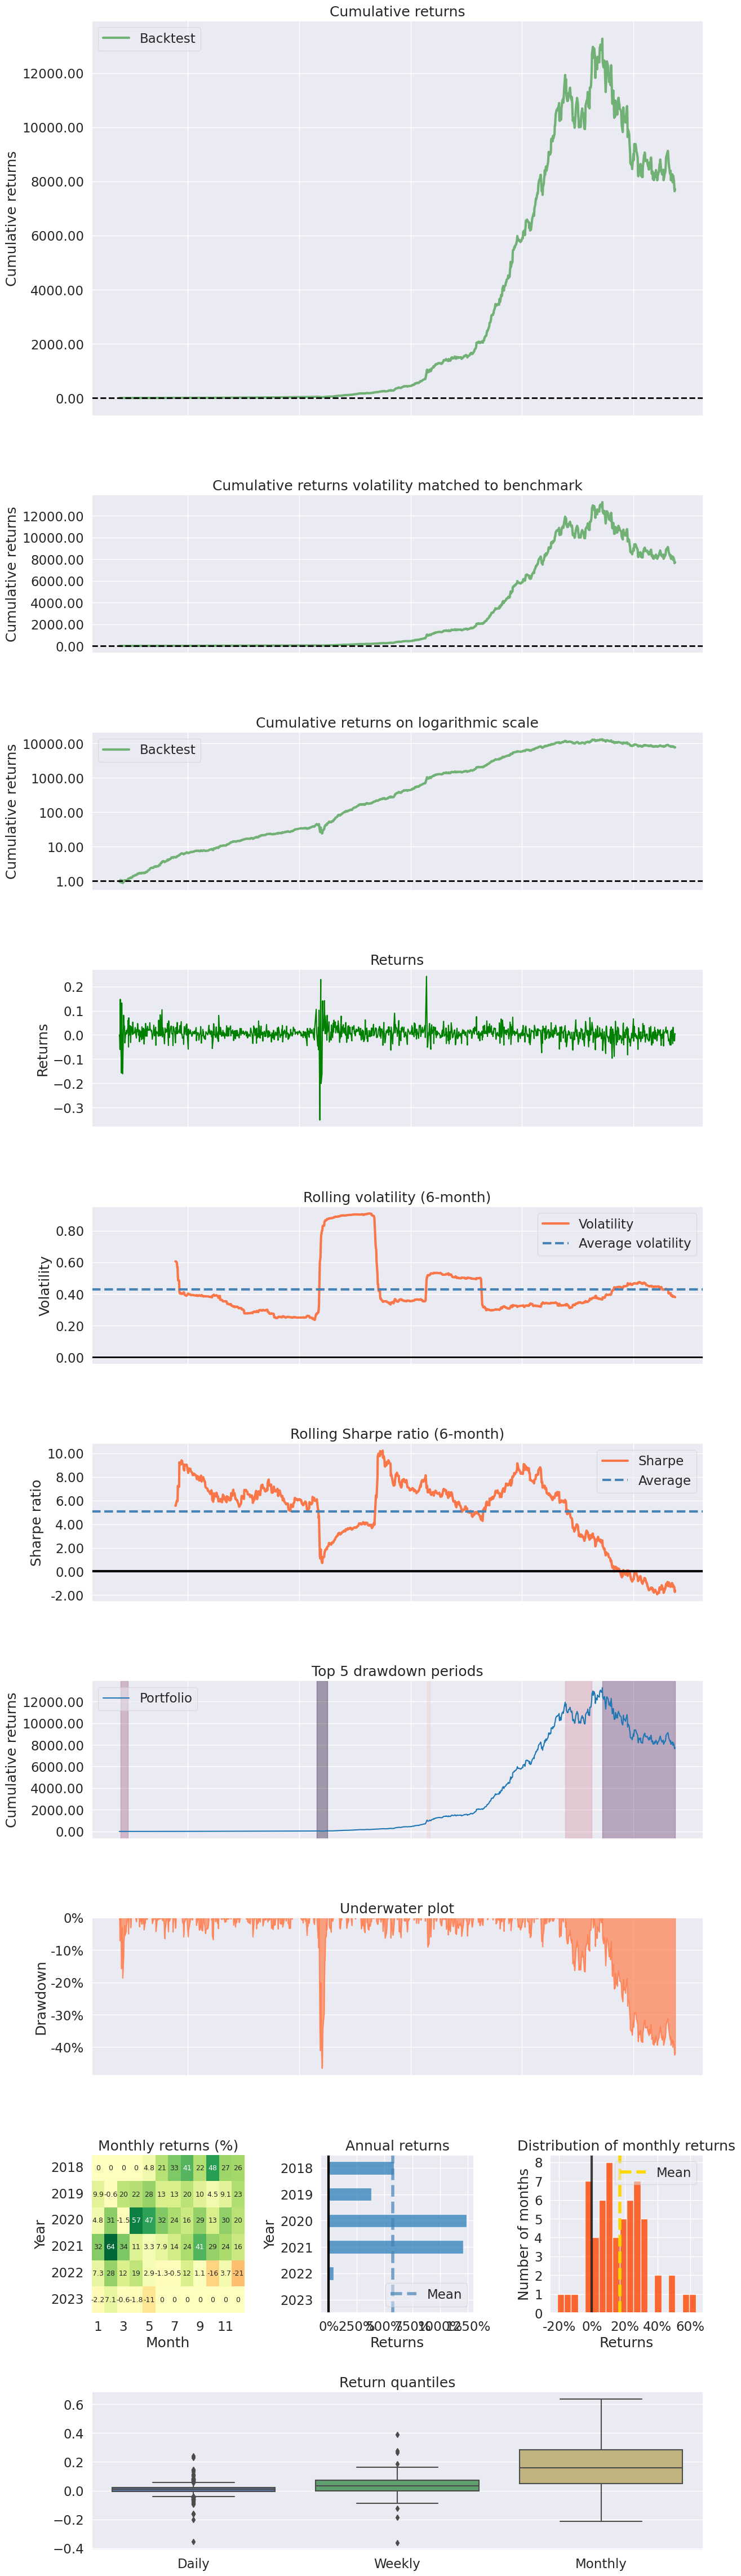

In [37]:
pf.create_returns_tear_sheet(df1.strategy)